# Data preparation

因為我自己擁有的硬體設備並不是很好，所以這次的檔案我選擇放在kaggle上面執行。

而Kaggle 在打開GPU加速的情況下，會縮減使用者可以使用的CPU以及RAM的容量。

在這個限制條件之下，如果我是直接將我們這次競賽所需要使用的檔案打開後接著就訓練模型，那麼Kaggle的notebook就會面臨記憶體不足的問題，之後整個Kernel就會被強制關掉。

因此為了避免這個問題，我們需要將我們的資料從json以及csv讀出來之後先進行預處裡，將不必要的資料去掉，並且重新儲存成一份新的json檔，如此一來在我們重新要開檔案的時候，就可以不用把很多沒有必要的資訊納入考量，也使我們的notebook可以在kaggle上面順利的運行。


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm, trange

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname,filename))
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
tweet_corpus = pd.read_json(files[0],lines=True)
data_type_csv = pd.read_csv(files[2])
emotion_csv = pd.read_csv(files[3])

In [ ]:
id_based_corpus = {}
for i in range(len(tweet_corpus)):
    id_based_corpus[tweet_corpus['_source'][i]['tweet']['tweet_id']] = tweet_corpus['_source'][i]['tweet']['text']

tweet_corpus['id'] = id_based_corpus.keys()
tweet_corpus['text'] = id_based_corpus.values()
tweet_corpus = tweet_corpus.drop(['_index','_score','_crawldate','_type','_source'], axis = 1)

In [ ]:
tweet_train_id = data_type_csv['tweet_id'][data_type_csv['identification'] == 'train']
tweet_test_id = data_type_csv['tweet_id'][data_type_csv['identification'] == 'test']
tweet_corpus_train = tweet_corpus[tweet_corpus['id'].isin(tweet_train_id)]
tweet_corpus_test = tweet_corpus[tweet_corpus['id'].isin(tweet_test_id)]
tweet_corpus_train = tweet_corpus_train.reset_index(drop=True)
tweet_corpus_test = tweet_corpus_test.reset_index(drop=True)

In [ ]:
tweet_corpus_train = (pd.merge(tweet_corpus_train,emotion_csv,left_on="id",right_on="tweet_id",sort=False)).drop(['tweet_id'],axis=1)
tweet_corpus_train['text'] = tweet_corpus_train['text'].apply(lambda x: x.replace("<LH>", ""))

In [ ]:
tweet_corpus_train.to_json('train_data.json')
tweet_corpus_test.to_json('test_data.json')

> 如此一來我們就順利的將預處理後的檔案保存下來了

我主要作了以下的預處理
1. 刪除不必要的行列
2. 將text當中一些奇怪的字元刪除， 例如: <LH>

接著就是進到模型的部分了

我的模型演進史當中主要經歷了三種模型

1.  首先一開始因為我看到baseline設定的不高，所以我使用groupby的方法找出了各個emotion label。
    而當中Joy含有最多的資料，因此我就將testing data全部設成joy後就交了出去。 出乎意料的是，這樣也取得了f-score 0.3062的成績

2. 再來才進到真的認真做的部分，首先我想要在不採用任何非必要的資料前處理的情況下進行訓練，因此基本上我就是參考lab2_preperation時的流程，再引入了當時使用的word2vec model後，我將我們tweet_corpus這一個dataframe當中的text一個一個丟進去 得到這一組text的word vector。
    接著就是將這一組word vector全部都餵進我自己搭建的一個2層的MLP當中做預測，而我將預測結果當中擁有最大的可能性的emotion當作這一筆推文的emotion。
    而這個出來的結果，距離我隨便亂猜joy的結果卻沒有好多少...

3. 所以這部分就是參考kaggle上各路大神們分享的notebook了，藉由使用老師上課提到的Roberta，終於取得了還算可以的成績


# Text Classification with RoBERTa

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu et al. It is based on Google’s BERT model released in 2018: it modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

See:
- RoBERTa's paper: https://arxiv.org/pdf/1907.11692.pdf
- BERT's paper: https://arxiv.org/pdf/1810.04805.pdf

In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [3]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

## Prepare dataset

Note that I have already cleaned the dataset, so the training should be better:
- Remove punctuation symbols and double white spaces.
- Lemmatization.
- Remove stop words (see `spacy.lang.en.stop_words.STOP_WORDS`).
- TD-IDF

The reason of this preprocess is that I have used this dataset with other models, such as LSTM. However, I believe (I didn't test it) that RoBERTa could deal with it.

In [4]:
df = pd.read_json('/kaggle/input/dm-lab2/train_data.json')
df.head()

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean raids box office ocean crime caper seque...,entertainment


In [5]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['category']].to_numpy().reshape(-1)

# Tokenize & encode

I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus **we must truncate the tokenized texts**. In my case, I truncate to 256 tokens, but you can put a higher value in the variable `MAX_LEN`.

See https://huggingface.co/roberta-base

In [11]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [12]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'entertainment', 1: 'sport', 2: 'business', 3: 'politics', 4: 'tech'}

In [13]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [14]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [15]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create RoBERTa model

In [16]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [17]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 256, 768), ( 124645632   input_word_ids[0][0]             
_____________________________________________________________________________________________

## Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [18]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3
25/25 [==============================] - 40s 2s/step - loss: 0.7000 - accuracy: 0.7258 - val_loss: 0.2181 - val_accuracy: 0.9341
Epoch 2/3
25/25 [==============================] - 4s 151ms/step - loss: 0.1183 - accuracy: 0.9627 - val_loss: 0.0710 - val_accuracy: 0.9746
Epoch 3/3
25/25 [==============================] - 4s 153ms/step - loss: 0.0265 - accuracy: 0.9936 - val_loss: 0.0474 - val_accuracy: 0.9850


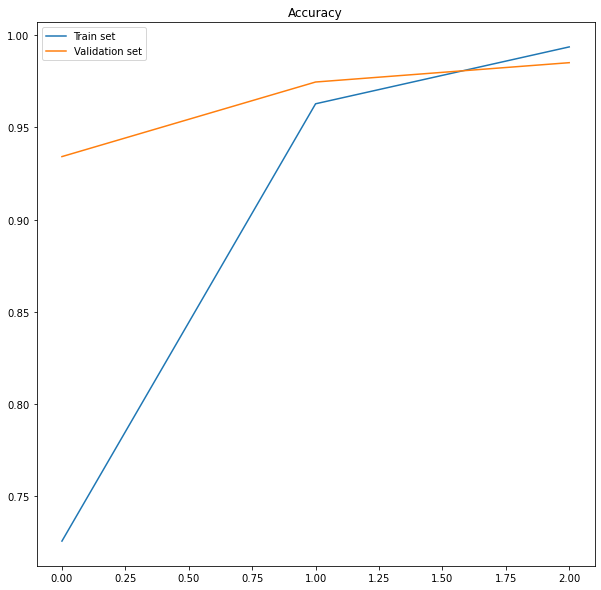

In [19]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [20]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 98.50%


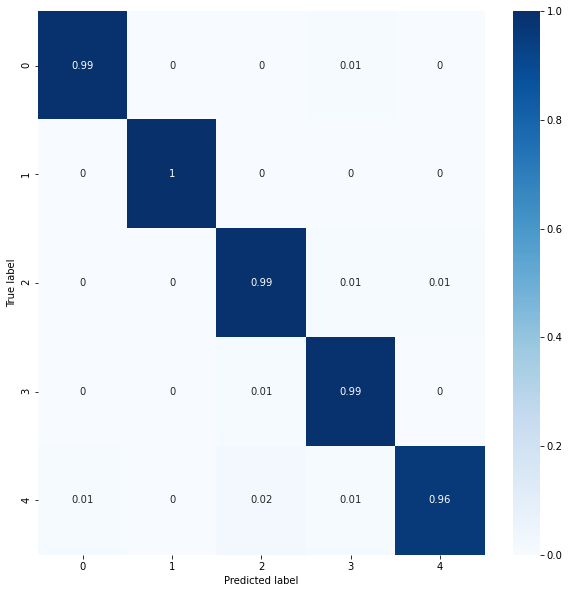

In [22]:
plot_confusion_matrix(X_test, y_test, model)